<a href="https://colab.research.google.com/github/paulamartingonzalez/GNN-expl/blob/main/GNNExplainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install dgl 

In [7]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.nn import GraphConv,EdgeWeightNorm
from random import randint
from torch.utils.data import DataLoader
from scipy.sparse import coo_matrix
from scipy import sparse
from functools import partial
import pandas as pd
import networkx as nx

Using backend: pytorch


# Create random graphs for graph classification

In [8]:
gs=[]
node_number = 20
initial_nodes = 2
node_feats=4


for i in range(25):
    G = nx.barabasi_albert_graph(node_number, initial_nodes)
    A = nx.adjacency_matrix(G)
    g = dgl.DGLGraph(A)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), node_feats)
    label = randint(0, 1)
    gs.append((g,label))

/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


# Define model

In [9]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.w = EdgeWeightNorm()
        self.out_act = nn.Sigmoid()

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return self.out_act(dgl.mean_nodes(g, 'h'))

# Dataloader

In [10]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [11]:
train_dataloader = DataLoader(gs, batch_size=int(10), shuffle=True,
                            collate_fn=collate)

# Train

In [12]:
# Create the model with given dimensions
model = GCN(4, 16, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        #edge_weight = (torch.randn(batched_graph.num_edges()) ** 2).requires_grad_() 
        #edge_weight = torch.tensor(batched_graph.adj(scipy_fmt='coo').todense())
        pred = model(batched_graph, batched_graph.ndata['h_n'].float())
        loss = loss_func(pred.round(), labels.unsqueeze(1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


# Get node importances

Select one graph:

In [13]:
graphs = dgl.unbatch(batched_graph)
G = graphs[2]
edge_weight = (torch.randn(G.num_edges()) ** 2).requires_grad_() 

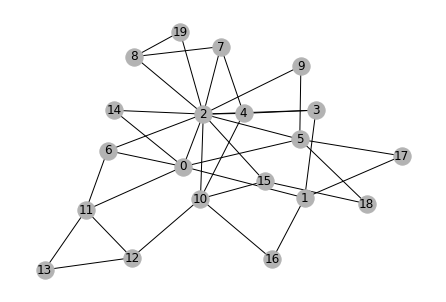

In [14]:
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

GNN explainer implementation taken from [https://github.com/ShaharGottlieb/GNNExplainer_DGL](https://github.com/ShaharGottlieb/GNNExplainer_DGL)

In [15]:
from math import sqrt
from tqdm import tqdm
import copy
import numpy as np
import dgl
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


class ExplainerTags:
    ORIGINAL_ID = '_explainer_original_id'
    EDGE_MASK = '_explainer_edge_mast'
    NODE_FEATURES = 'explainer_feature'


# UDF for message passing. this will execute after all the previous messages, and mask the final massage.
def mask_message(edges):
    edata = edges.data['m']
    emask = edges.data[ExplainerTags.EDGE_MASK].sigmoid().view(-1, 1)
    masked_message = (edata.view(edata.shape[0], -1) * emask).view(edata.shape)
    return {'m': masked_message}


# workaround to hijack the "update_all" function of DGL
class ExplainGraph(dgl.DGLGraph):
    def update_all(self, message_func, reduce_func, apply_node_func=None, etype=None):
        super().apply_edges(message_func)
        super().update_all(mask_message, reduce_func, apply_node_func, etype)


class GNNExplainer:
    """
        TODO - add info
    """
    # hyper parameters, taken from the original paper
    params = {
        'edge_size': 0.005,
        'feat_size': 0.5,
        'edge_ent': 1.0,
        'feat_ent': 0.1,
        'eps': 1e-15
    }

    def __init__(self, graph: dgl.DGLGraph, model: nn.Module, num_hops: int,
                 epochs: int = 100, lr: float = 0.01,
                 mask_threshold: float = 0.5, edge_size: float = 0.005, feat_size: float = 0.1):
        """
        :param graph: dgl base graph
        :param model: model to explain
        :param num_hops: number of message passing layers in model
        :param epochs: number of epochs to optimize explainer
        :param lr: learning rate
        :param mask_threshold: threshold for hard-mask at return
        """
        self.g: dgl.DGLGraph = graph
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.threshold = mask_threshold
        self.num_hops = num_hops
        self.feature_mask = None
        self.params['edge_size'] = edge_size
        self.params['feat_size'] = feat_size
        self.nfeat = ExplainerTags.NODE_FEATURES
        for module in self.model.modules():
            if hasattr(module, '_allow_zero_in_degree'):
                module._allow_zero_in_degree = True

    def __set_masks__(self, g: dgl.DGLGraph):
        """ set masks for edges and features """
        num_feat = g.ndata[self.nfeat].shape[1:]
        self.feature_mask = nn.Parameter(torch.randn(num_feat) * 0.1)

        std = nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * g.num_nodes()))
        g.edata[ExplainerTags.EDGE_MASK] = nn.Parameter(torch.randn(g.num_edges()) * std)

    @staticmethod
    def __apply_feature_mask__(feat, mask):
        mask_sig = mask.view(1, -1).sigmoid()
        return feat * mask_sig

    def __loss__(self, g, node_idx, log_logits, pred_label):
        # prediction loss
        if node_idx is None:  # graph classification
            loss = -log_logits.view(-1)[pred_label]
        else:
            loss = -log_logits[node_idx, pred_label[node_idx]]

        # edge loss
        me = g.edata[ExplainerTags.EDGE_MASK].sigmoid()
        loss = loss + torch.sum(me) * self.params['edge_size']  # edge regularization - subgraph size
        entropy = -me * torch.log(me + self.params['eps']) - (1 - me) * torch.log(1 - me + self.params['eps'])
        loss = loss + self.params['edge_ent'] * entropy.mean()  # edge los: entropy + regularization

        # node features loss
        mn = self.feature_mask.sigmoid()
        loss = loss + torch.mean(mn) * self.params['feat_size']  # node feature regularization
        entropy = -mn * torch.log(mn + self.params['eps']) - (1 - mn) * torch.log(1 - mn + self.params['eps'])
        loss = loss + self.params['feat_ent'] * entropy.mean()  # node feature los: entropy + regularization
        # print(log_logits, loss)
        return loss

    def _predict(self, graph, model, node_id, feat_mask=None):
        model.eval()
        feat = graph.ndata[self.nfeat]
        if feat_mask is not None:
            feat = feat * feat_mask
        with torch.no_grad():
            log_logits = model(graph, feat)
            pred_label = log_logits.argmax(dim=-1)

        if node_id is None:   # graph classification
            return log_logits, pred_label
        else:    # node classification
            return log_logits[node_id], pred_label[node_id]

    def _create_subgraph(self, node_idx):
        """ get all nodes that contribute to the computation of node's embedding """
        if node_idx is None:  # graph classification
            sub_g = copy.deepcopy(self.g)
            sub_g.ndata[ExplainerTags.ORIGINAL_ID] = torch.range(0, self.g.num_nodes() - 1, dtype=torch.int)
        else:
            nodes = torch.tensor([node_idx])
            eid_list = []
            for _ in range(self.num_hops):
                predecessors, _, eid = self.g.in_edges(nodes, form='all')
                eid_list.extend(eid)
                predecessors = torch.flatten(predecessors).unique()
                nodes = torch.cat([nodes, predecessors])
                nodes = torch.unique(nodes)
            eid_list = list(np.unique(np.array([eid_list])))
            sub_g = dgl.edge_subgraph(self.g, eid_list)  # TODO - handle heterogeneous graphs
            sub_g.ndata[ExplainerTags.ORIGINAL_ID] = sub_g.ndata[dgl.NID]
        return sub_g

    def explain_node(self, node_idx):
        """ main function - calculate explanation """
        # get prediction label
        self.model.eval()
        feat = self.g.ndata[self.nfeat]
        device = feat.device
        with torch.no_grad():
            log_logits = self.model(self.g, feat)
            pred_label = log_logits.argmax(dim=-1)

        # create initial subgraph (all nodes and edges that contribute to the explanation)
        subgraph = self._create_subgraph(node_idx)
        if node_idx is None:  # graph classification
            new_node_id = None
            pred_label = pred_label
        else:  # node classification
            new_node_id = np.where(subgraph.ndata[ExplainerTags.ORIGINAL_ID] == node_idx)[0][0]
            pred_label = pred_label[subgraph.ndata[ExplainerTags.ORIGINAL_ID]]

        # "trick" the graph so we can hijack its calls
        original_graph_class = subgraph.__class__
        subgraph.__class__ = ExplainGraph  # super hacky, but i find it elegant in it's own way.

        # set feature and edge masks
        self.__set_masks__(subgraph)
        feat = subgraph.ndata[self.nfeat]
        # move to device
        self.feature_mask.to(device)
        subgraph.to(device)

        # start optimizing
        optimizer = torch.optim.Adam([self.feature_mask, subgraph.edata[ExplainerTags.EDGE_MASK]], lr=self.lr)

        pbar = tqdm(total=self.epochs)
        pbar.set_description('Explaining node {}'.format(node_idx))
        # training loop
        for epoch in range(1, self.epochs + 1):
            h = self.__apply_feature_mask__(feat, self.feature_mask)  # soft mask features
            log_logits = self.model(subgraph, h)         # get prediction (will mask edges inside dgl.graph.update_all)
            loss = self.__loss__(subgraph, new_node_id, log_logits, pred_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(loss.detach())
            pbar.update(1)
        pbar.close()
        subgraph.__class__ = original_graph_class

        # get hard node feature mask and edge mask
        node_feat_mask = self.feature_mask.detach().sigmoid() > self.threshold
        edge_mask = subgraph.edata[ExplainerTags.EDGE_MASK].detach().sigmoid()
        subgraph.remove_edges(np.where(edge_mask < self.threshold)[0])

        # remove isolated nodes from subgraph
        isolated_nodes = np.where((subgraph.in_degrees() == 0) & (subgraph.out_degrees() == 0))[0]
        if node_idx is not None:  # node classification
            # don't delete our node in any case..
            isolated_nodes = isolated_nodes[isolated_nodes != new_node_id]
        if sum(isolated_nodes) != subgraph.number_of_nodes():
            subgraph.remove_nodes(isolated_nodes)
        return subgraph, node_feat_mask

    def test_explanation(self, node_id, subgraph, feat_mask):
        """ print explanation results- reduced size, and accuracy
        :param node_id: original node id which we explained
        :param subgraph: result from GNNExplainer.explain_node
        :param feat_mask: result from GNNExplainer.explain_node
        """
        # get node prediction for original task
        log_logit_original, label_original = self._predict(self.g, self.model, node_id)
        # mapping to new subgraph node id
        if node_id is None:  # graph classification
            new_node_id = None
        else:   # node classification
            new_node_id = np.where(subgraph.ndata[ExplainerTags.ORIGINAL_ID] == node_id)[0][0]
        # current prediction results
        log_logit, label = self._predict(subgraph, self.model, new_node_id, feat_mask)
        # create subgraph needed for computation, for size reference
        origin_sub_g = self._create_subgraph(node_id)
        # print results
        print("subgraph size before masking (V,E)=({}, {})".format(origin_sub_g.num_nodes(), origin_sub_g.num_edges()))
        print("subgraph size after masking  (V,E)=({}, {})".format(subgraph.num_nodes(), subgraph.num_edges()))
        print("num features before masking: {}".format(torch.numel(feat_mask)))
        print("num features after masking: {}".format(feat_mask.sum()))
        print("log_logits before masking: {}".format(log_logit_original))
        print("log_logits after masking: {}".format(log_logit))
        print("label before masking: {}".format(label_original))
        print("label after masking: {}".format(label))

    def _visualize(self, subgraph, nlabel_mapping=None, title=""):
        num_classes = int(torch.max(self.g.ndata['label']).item()) + 1
        nx_g = dgl.to_networkx(subgraph, node_attrs=['label', ExplainerTags.ORIGINAL_ID])
        mapping = {i: nx_g.nodes[i][ExplainerTags.ORIGINAL_ID].item() for i in nx_g.nodes.keys()}
        node_labels = [nx_g.nodes[i]['label'].item() for i in nx_g.nodes.keys()]

        cmap = plt.get_cmap('cool', num_classes)
        cmap.set_under('gray')

        node_kwargs = {'node_size': 400, 'cmap': cmap, 'node_color': node_labels, 'vmin': 0, 'vmax': num_classes-1}
        label_kwargs = {'labels': mapping, 'font_size': 10}

        pos = nx.spring_layout(nx_g)
        ax = plt.gca()
        for source, target, data in nx_g.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=1.0,  # max(data['att'], 0.1), # TODO - change for transparent visualization mode
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))
        nx.draw_networkx_labels(nx_g, pos, **label_kwargs)
        nx.draw_networkx_nodes(nx_g, pos, **node_kwargs)
        if nlabel_mapping is None:
            nlabel_mapping = {i: i for i in range(num_classes)}
        patch_list = [mpatches.Patch(color=cmap(i), label=nlabel_mapping[i]) for i in range(num_classes)]
        ax.legend(handles=patch_list, title="Label", loc=1)
        if title is not None:
            plt.title(title)
        plt.show()

    def visualize(self, subgraph, node_id, nlabel_mapping=None, title=""):
        """
        visualize explanation
        :param subgraph: result from GNNExplainer.explain_node
        :param node_id: node id used to explain
        :param nlabel_mapping: mapping between node label to text, to be printed in legend
        :param title: optional title for graph
        """
        self._visualize(self._create_subgraph(node_id), nlabel_mapping, title)
        self._visualize(subgraph, nlabel_mapping, title)




Try with our random graphs

In [ ]:
model.eval()
num_hops = 2
graph_label = 178
g = G
g.ndata[ExplainerTags.NODE_FEATURES] = g.ndata['h_n'].float().to(torch.device("cpu"))
explainer = GNNExplainer(g, model, num_hops, epochs=100, edge_size=0.05, feat_size=0)
subgraph, feat_mask = explainer.explain_node(None)
explainer.test_explanation(None, subgraph, feat_mask)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
Explaining node None:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Explaining node None: 100%|██████████| 100/100 [00:00<00:00, 168.25it/s]

In [3]:
label_mapping = {0: 'C', 1: 'N', 2: 'O', 3: 'F', 4: 'I', 5: 'Cl', 6: 'Br'}
explainer.visualize(subgraph, None, label_mapping, "Mutagenic label {}".format(dataset.labels[graph_label]))

NameError: ignored